<a href="https://colab.research.google.com/github/Apolinar97/CS497_tweet_sentiment_analysis/blob/master/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#provide acess to drive.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#locate csv file and download/load it.
downloaded = drive.CreateFile({'id':'166vhh0NJH_DyhTMYTnt-aQKkN7RyO9F2'})
downloaded.GetContentFile('Tweets.csv') 

In [0]:
try:
  %tensorflow_version 2.x
except:
  pass

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [72]:
#clean data
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords


df = pd.read_csv('Tweets.csv')
col_to_drop = ['tweet_id','airline_sentiment_confidence',
              'negativereason', 'negativereason_confidence', 'airline',
              'airline_sentiment_gold', 'name', 'negativereason_gold',
              'retweet_count','tweet_coord', 'tweet_created',
              'tweet_location', 'user_timezone']
df.drop(col_to_drop,axis=1, inplace=True)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
def norm_tweet(tweet):
  tweet = tweet.lower()
  tweet = re.sub('(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)', ' ', tweet)
  tweet = re.sub('[^a-z]+', ' ', tweet)
  return tweet

def tokenize_tweet(tweet):
  tweet_tk = TweetTokenizer()
  return(tweet_tk.tokenize(tweet))


def remove_stopwords(tweet_tokens):
  stop_words = stopwords.words('english')
  return([word for word in tweet_tokens if word not in stop_words])

def remove_stopwords_for_analysis(tweet):
  stop_words = stopwords.words('english')
  white_list = ['no', 'not']
  words_tweet = tweet.split()
  clean_tweet = [word for word in words_tweet if(word not in stop_words or word in white_list)]
  return ' '.join(clean_tweet)

In [0]:
#clean df for basic EDA
df['text'] = df['text'].map(norm_tweet)
df['text'] = df['text'].map(tokenize_tweet)
df['text'] = df['text'].map(remove_stopwords)

In [75]:
#Conduct EDA
df.groupby(['airline_sentiment']).count()

,text
airline_sentiment,
negative,9178
neutral,3099
positive,2363


<function matplotlib.pyplot.show>

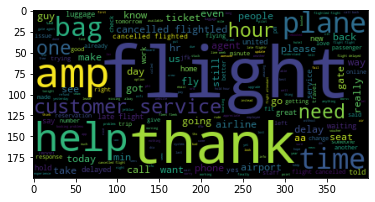

In [76]:
from wordcloud import WordCloud
wordcloud = WordCloud()
wordcloud.generate(' '.join((np.concatenate(df.text.values))))
plt.imshow(wordcloud)
plt.show

In [0]:
ana_df = pd.read_csv('Tweets.csv')
ana_df.drop(col_to_drop,axis=1, inplace=True)

ana_df['airline_sentiment'].replace({'neutral': 2 , 'positive': 1, 'negative':0}, inplace=True)
ana_df['text'] = ana_df['text'].map(norm_tweet)
ana_df['text'] = ana_df['text'].map(remove_stopwords_for_analysis)


In [0]:
from collections import Counter
#prepare data for training
NUM_WORDS = 10000
X_train, X_test, y_train, y_test = train_test_split(ana_df.text, ana_df.airline_sentiment, test_size = 1/3)

tkn = tf.keras.preprocessing.text.Tokenizer(num_words=NUM_WORDS, lower=True, split=' ')

tkn.fit_on_texts(X_train)

#X_train_seq = tkn.texts_to_sequences(X_train)
#X_test_seq = tkn.texts_to_sequences(X_test)


In [0]:
#one hot training
X_train_oh = tkn.texts_to_matrix(X_train,mode='binary')
X_test_oh = tkn.texts_to_matrix(X_test, mode='binary')

#encode labels
label_encoder = LabelEncoder()

#convert labels to oh 
y_train_oh = tf.keras.utils.to_categorical(label_encoder.fit_transform(y_train))
y_test_oh = tf.keras.utils.to_categorical(label_encoder.fit_transform(y_test))


Adress issue of overfitting. Removed one layer and decreased the units from 64 to 32.

In [80]:
#init model
sentiment_model = tf.keras.Sequential()
sentiment_model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=[NUM_WORDS,]))
sentiment_model.add(tf.keras.layers.Dense(64, activation='relu'))
sentiment_model.add(tf.keras.layers.Dense(3, activation='softmax'))

sentiment_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 64)                640064    
_________________________________________________________________
dense_44 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_45 (Dense)             (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [81]:
sentiment_model.compile(optimizer='rmsprop',
                        loss='categorical_crossentropy',
                        metrics = ['acc'] )

history = sentiment_model.fit(X_train_oh, y_train_oh, epochs=20, batch_size=512, validation_data=(X_test_oh,y_test_oh))

Epoch 1/20
20/20 [==============================] - 1s 58ms/step - loss: 0.8250 - acc: 0.6274 - val_loss: 0.7188 - val_acc: 0.6455
Epoch 2/20
20/20 [==============================] - 1s 53ms/step - loss: 0.6018 - acc: 0.7348 - val_loss: 0.6126 - val_acc: 0.7689
Epoch 3/20
20/20 [==============================] - 1s 52ms/step - loss: 0.4714 - acc: 0.8481 - val_loss: 0.5472 - val_acc: 0.7926
Epoch 4/20
20/20 [==============================] - 1s 52ms/step - loss: 0.3597 - acc: 0.8875 - val_loss: 0.5467 - val_acc: 0.7963
Epoch 5/20
20/20 [==============================] - 1s 68ms/step - loss: 0.2925 - acc: 0.9073 - val_loss: 0.5471 - val_acc: 0.7949
Epoch 6/20
20/20 [==============================] - 1s 67ms/step - loss: 0.2391 - acc: 0.9215 - val_loss: 0.5836 - val_acc: 0.7885
Epoch 7/20
20/20 [==============================] - 1s 53ms/step - loss: 0.2071 - acc: 0.9321 - val_loss: 0.6126 - val_acc: 0.7764
Epoch 8/20
20/20 [==============================] - 1s 53ms/step - loss: 0.1698 - a

Applied regularization to decrease further overfitting.

In [0]:
sentiment_model_reg = tf.keras.Sequential()
sentiment_model_reg.add(tf.keras.layers.Dense(32, activation='relu', 
                                              kernel_regularizer= tf.keras.regularizers.l2(l=0.01), 
                                              input_shape=[NUM_WORDS,]))

sentiment_model_reg.add(tf.keras.layers.Dense(32,activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
sentiment_model_reg.add(tf.keras.layers.Dense(3, activation='softmax'))

In [84]:
results = sentiment_model_reg.evaluate(X_test_oh, y_test_oh)


153/153 [==============================] - 0s 2ms/step - loss: 0.6872 - acc: 0.7875


val_acc stops increasing at epoch 24. Stop training

In [87]:
sentiment_model_reg.compile(optimizer='rmsprop',
                        loss='categorical_crossentropy',
                        metrics = ['acc'])

history_reg = sentiment_model_reg.fit(X_train_oh, y_train_oh, epochs=24, batch_size=512, validation_data=(X_test_oh, y_test_oh))

Epoch 1/24
20/20 [==============================] - 1s 47ms/step - loss: 0.5786 - acc: 0.8238 - val_loss: 0.6795 - val_acc: 0.7754
Epoch 2/24
20/20 [==============================] - 1s 42ms/step - loss: 0.5480 - acc: 0.8444 - val_loss: 0.6690 - val_acc: 0.7881
Epoch 3/24
20/20 [==============================] - 1s 43ms/step - loss: 0.5296 - acc: 0.8536 - val_loss: 0.6703 - val_acc: 0.7877
Epoch 4/24
20/20 [==============================] - 1s 41ms/step - loss: 0.5340 - acc: 0.8568 - val_loss: 0.6581 - val_acc: 0.7955
Epoch 5/24
20/20 [==============================] - 1s 40ms/step - loss: 0.5305 - acc: 0.8611 - val_loss: 0.6760 - val_acc: 0.7908
Epoch 6/24
20/20 [==============================] - 1s 41ms/step - loss: 0.5339 - acc: 0.8622 - val_loss: 0.6687 - val_acc: 0.7922
Epoch 7/24
20/20 [==============================] - 1s 40ms/step - loss: 0.5312 - acc: 0.8620 - val_loss: 0.6659 - val_acc: 0.7906
Epoch 8/24
20/20 [==============================] - 1s 40ms/step - loss: 0.5401 - a

In [85]:
#TODO add word embedding layer.
print(f"Accuracy score: {results[1]}")


Accuracy score: 0.7875000238418579


In [0]:
#save model to drive: 
sentiment_model_reg.save('sentiment_model_reg.h5')
mod_file = drive.CreateFile({'title': 'sentiment_model_reg.h5'})
mod_file.SetContentFile('sentiment_model_reg.h5')
mod_file.Upload()